<a href="https://colab.research.google.com/github/sturu1/Mon-AM/blob/master/2020_08_03_%EC%98%A4%EC%A0%84%EC%88%98%EC%97%85_%EC%9D%B4%EB%AF%B8%EC%A7%80%EB%B6%84%ED%95%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 이미지 분할 (9.5파트)
 
https://chloevan.github.io/python/tensorflow2.0/ch9_5_image_segmentation/

https://medium.com/hyunjulie/1%ED%8E%B8-semantic-segmentation-%EC%B2%AB%EA%B1%B8%EC%9D%8C-4180367ec9cb

https://www.whydsp.org/318

https://divamgupta.com/image-segmentation/2019/06/06/deep-learning-semantic-segmentation-keras.html

1. RedNet를 이용하여 이미지 분할 문제에 적용해보기
2. Oxford Pet Dataset 불러오기

In [42]:
import tensorflow_datasets as tfds
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=oxford_iiit_pet:3.1.0
datasets, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

2020-08-03 06:30:48.780218: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
I0803 06:30:51.340755 139706161162112 download_and_prepare.py:180] Running download_and_prepare for datasets:
oxford_iiit_pet:3.1.0
I0803 06:30:51.341460 139706161162112 download_and_prepare.py:181] Version: "None"
I0803 06:30:51.342164 139706161162112 dataset_builder.py:199] Overwrite dataset info from restored data version.
I0803 06:30:51.345462 139706161162112 download_and_prepare.py:130] download_and_prepare for dataset oxford_iiit_pet/3.1.0...
I0803 06:30:51.345773 139706161162112 dataset_builder.py:285] Reusing dataset oxford_iiit_pet (/root/tensorflow_datasets/oxford_iiit_pet/3.1.0)
name: "oxford_iiit_pet"
description: "The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200\nimages for each class. The images have large variations in scale, pose and\nlighting. All images have an associated ground truth annotatio

In [43]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.1.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.
',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and J

#이미지 가져오기

1. 

In [44]:
import tensorflow as tf
import numpy as np

info.splits['train']
train_data_len = info.splits['train'].num_examples
test_data_len = info.splits['test'].num_examples
print(train_data_len, test_data_len)

3680 3669


In [45]:
#불규칙한 이미지 차원을 균일한 차원으로 바꾸어 주는 함수

def load_image(datapoint):
  img = tf.image.resize(datapoint['image'], (128, 128))
  mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  img = tf.cast(img, tf.float32)#자료형 변환
  img = img / 255.0 #정규화 0~1로 만듬
  mask = mask - 1 #마스크 레이블 기존 123 -> 012 로 변경
  return img, mask

In [46]:
train_dataset = datasets['train'].map(load_image)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(8)

test_dataset = datasets['test'].map(load_image)
test_dataset = test_dataset.repeat()
test_dataset = test_dataset.batch(1)

#데이터 가시화

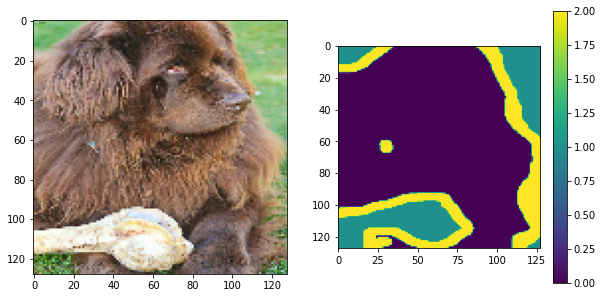

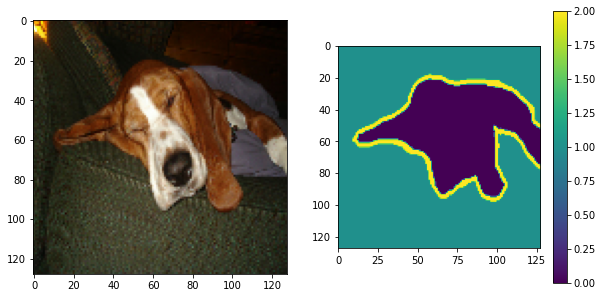

In [47]:
import matplotlib.pyplot as plt

imgidx = 7

for img, mask in train_dataset.take(2): # c=1개의 배치 배치를 가져와라 
  plt.figure(figsize=(10, 5))

  plt.subplot(1, 2, 1)
  plt.imshow(img[imgidx]) #가져온 배치 내에서 0번째 이미지 0~15까지 index

  plt.subplot(1, 2, 2)
  plt.imshow(np.squeeze(mask[imgidx], axis=2))
  plt.colorbar()

#Segmentation(이미지 분할)을 위한 REDNet 정의

In [48]:
def REDNet_segmentation(num_layers):
  conv_layers = []
  deconv_layers = []
  residual_layers = []
#입력 레이어 정의 : None으로 해놓으면 임의의 차원을 모두  입력으로 받을 수 있음
  inputs = tf.keras.layers.Input(shape=(None, None, 3))
#처음 입력영상 처리하는 부분은 3채널로써 먼저 con layer하나를 미리 담아준다.
  conv_layers.append(tf.keras.layers.Conv2D(3, kernel_size=3, padding='same', activation='relu'))

  for i in range(num_layers-1):#0~13, 14번
    conv= tf.keras.layers.Conv2D(64, kernel_size=3, padding='same',activation='relu')#convolution
    deconv=  tf.keras.layers.Conv2DTranspose(64, kernel_size=3, padding='same', activation='relu')#deconvolution

    conv_layers.append(conv)#conv 레이어 적재
    deconv_layers.append(deconv)#deconv 레이어 적재

  deconv_layers.append(tf.keras.layers.Conv2DTranspose(3, kernel_size=3, padding='same', activation ='softmax'))#채널이 3개이니깐 3임
#softmax를 추가해서 pixelwise classification 문제를 해결하도록 수정

#  총 30개의 레이어 오브젝트가 준비되었음

# 인코딩 path 연결을 시작
  x = conv_layers[0](inputs)#빨간색 #첫번째 레이어 먼저 처리
  
  for i in range(num_layers-1):# 0~13
    x = conv_layers[i+1](x)#conv 레이어들 쭉쭉 연결
    
    if i % 2 == 0: #짝
    #slip connection으로 나중에 deconvolution할떄 연결해주기위해서 중간 값들을 저장함.
      residual_layers.append(x)
#디코딩할때는 최근 인코딩한거부터 시작됨

  #디코딩 path연결 시작
  for i in range(num_layers-1):#0~13
    if i % 2 == 1:
      x = tf.keras.layers.Add()([x, residual_layers.pop()])#pop은 가장 마지막에 들어갔던 순서로 꺼냄
      x = tf.keras.layers.Activation('relu')(x)#P363그림으로 확인가능

    x = deconv_layers[i](x)#Deconvolution 항상하는것

  x = deconv_layers[-1](x)

  model = tf.keras.Model(inputs=inputs, outputs=x)
  return model

# 모델 환경설정

In [49]:
model = REDNet_segmentation(15)
model.compile(optimizer = tf.optimizers.Adam(0.0001),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [61]:
history = model.fit(train_dataset, epochs = 5, steps_per_epoch = train_data_len//16,
                    validation_data = test_dataset, validation_steps = test_data_len)
#epochs이 늘면 더 정확하게 구분가능하다.

Epoch 1/5
230/230 [==============================] - 209s 908ms/step - loss: 0.8683 - accuracy: 0.5853 - val_loss: 0.8014 - val_accuracy: 0.5748
Epoch 2/5
230/230 [==============================] - 208s 904ms/step - loss: 0.7742 - accuracy: 0.6285 - val_loss: 0.7583 - val_accuracy: 0.6380
Epoch 3/5
230/230 [==============================] - 209s 908ms/step - loss: 0.7051 - accuracy: 0.6884 - val_loss: 0.6744 - val_accuracy: 0.7099
Epoch 4/5
230/230 [==============================] - 212s 923ms/step - loss: 0.6572 - accuracy: 0.7171 - val_loss: 0.6263 - val_accuracy: 0.7279
Epoch 5/5
230/230 [==============================] - 211s 916ms/step - loss: 0.6347 - accuracy: 0.7298 - val_loss: 0.6097 - val_accuracy: 0.7422


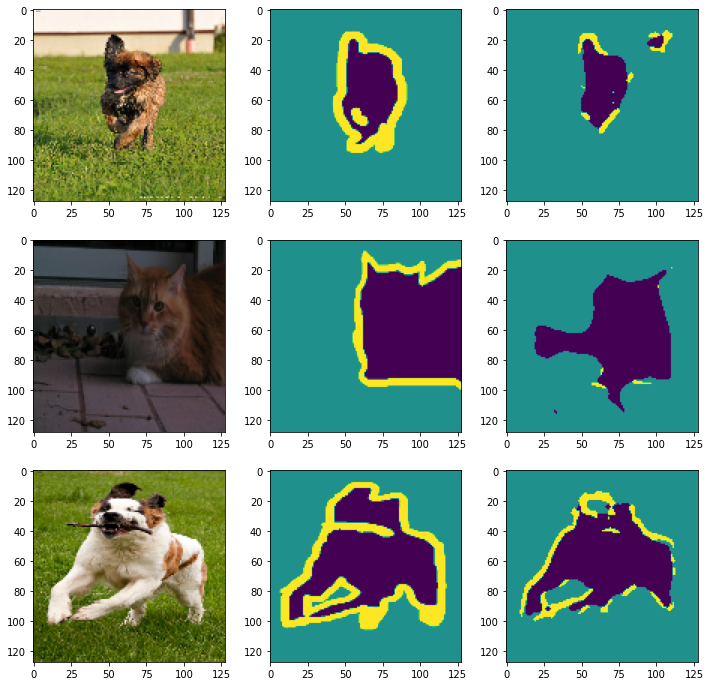

In [63]:
plt.figure(figsize = (12, 12))

for idx, (img, mask) in enumerate(test_dataset.take(3)):
  plt.subplot(3, 3, idx*3+1)#이미지

  plt.imshow(img[0])

  plt.subplot(3, 3, idx*3+2)#마스크
  plt.imshow(np.squeeze(mask[0], axis=2))

  predict = tf.argmax(model.predict(img), axis=-1)
  plt.subplot(3, 3, idx*3+3)
  plt.imshow(np.squeeze(predict, axis=0))#학습이 덜 되었으면 predict뒤에 아무것도 삽입하지말것.원래는 predict[0]이다.